# Callin Switzer
### 6 June 2019
___
### - Train Dense, Feedforward Neural Network with Keras
### - Train with fully actuated system
### - Pur velocity as input to network, with only the four controls as output

___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\PythonGeneratedData_twoTorque'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/DataOutput_twoTorque'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-06-12 13:25:12.435125


In [2]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [3]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "twoTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [4]:
con1 = sqlite3.connect(os.path.join(dataDir, "twoTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [5]:
trainDF.head()

,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0,tau_w
0,0.0,1147.407904,0.0,-238.429602,1.123847,23.498330,4.482445,12.691013,18.723606,691.882850,-4.739545,-293.363224,4.014081,308.066760,8.139222,345.558353,30853.584922,1.797866,-546297.092872,10262.953817
1,0.0,-1152.043723,0.0,369.845453,4.645359,5.927584,3.398032,-19.816137,-23.448395,-706.563802,8.272804,684.314462,14.631620,851.354510,11.946214,778.225185,31872.475362,2.658456,961528.396769,36965.947717
2,0.0,-592.993151,0.0,-525.687613,5.220594,6.983077,4.307985,-23.696882,-4.641471,-608.960470,-5.348081,430.757954,9.520878,942.874265,8.779522,955.717081,21305.283236,2.463747,-313643.967698,45809.941477
3,0.0,1338.965230,0.0,61.191760,3.628833,-17.119889,2.109267,-11.436424,26.318800,623.841539,0.005384,863.443021,16.589887,1316.282852,15.180057,1307.874474,19428.750439,0.374967,-203911.489339,47599.081146
4,0.0,-1361.776972,0.0,664.606866,1.468084,8.355107,0.008353,8.528276,-27.521247,-1473.234824,14.165396,774.628129,3.269968,165.211558,1.712961,160.158577,8084.383659,1.102396,63102.747684,6365.517419


In [6]:
testDF.head()

,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0,tau_w
0,0.0,1290.475733,0.0,1031.459220,5.901014,9.348979,3.643856,17.157149,26.235253,1137.037978,20.847415,289.689136,18.537756,1221.875359,15.098098,1167.837706,10507.464077,0.559591,799932.656919,61301.505115
1,0.0,-643.287407,0.0,-812.471891,0.923325,5.317080,3.764966,-24.582937,-9.018544,-1514.026571,-11.076141,-1014.695373,-10.546085,-1478.783791,-6.871128,-1435.593398,34686.690435,1.063056,-737949.278098,-97316.403803
2,0.0,817.563373,0.0,-1295.713095,3.073726,4.217052,0.532687,-4.945442,13.080550,-325.919134,-23.274466,-817.967701,17.014216,1687.486984,14.956286,1693.827720,27441.473272,0.549398,-575984.856139,87908.705311
3,0.0,-818.423313,0.0,1230.998812,0.037942,-24.356912,1.783597,17.914569,-13.849188,-1982.346897,19.697223,1963.656391,-11.793649,-1541.793049,-10.608393,-1556.139800,4053.551364,3.837047,617346.567027,-53108.537683
4,0.0,-1240.409449,0.0,-1375.065310,3.503992,9.262691,2.659674,-6.227951,-10.039456,-1427.009664,-9.628598,-1844.939378,5.908790,590.782422,4.559646,516.295982,17916.938852,1.558088,967963.511996,52430.831318


In [7]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [8]:
print(trainDF.shape)
trainDF.head()

(10000000, 20)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0,tau_w
0,0.0,1147.407904,0.0,-238.429602,1.123847,23.498330,4.482445,12.691013,18.723606,691.882850,-4.739545,-293.363224,4.014081,308.066760,8.139222,345.558353,30853.584922,1.797866,-546297.092872,10262.953817
1,0.0,-1152.043723,0.0,369.845453,4.645359,5.927584,3.398032,-19.816137,-23.448395,-706.563802,8.272804,684.314462,14.631620,851.354510,11.946214,778.225185,31872.475362,2.658456,961528.396769,36965.947717
2,0.0,-592.993151,0.0,-525.687613,5.220594,6.983077,4.307985,-23.696882,-4.641471,-608.960470,-5.348081,430.757954,9.520878,942.874265,8.779522,955.717081,21305.283236,2.463747,-313643.967698,45809.941477
3,0.0,1338.965230,0.0,61.191760,3.628833,-17.119889,2.109267,-11.436424,26.318800,623.841539,0.005384,863.443021,16.589887,1316.282852,15.180057,1307.874474,19428.750439,0.374967,-203911.489339,47599.081146
4,0.0,-1361.776972,0.0,664.606866,1.468084,8.355107,0.008353,8.528276,-27.521247,-1473.234824,14.165396,774.628129,3.269968,165.211558,1.712961,160.158577,8084.383659,1.102396,63102.747684,6365.517419


In [9]:
# rename columns to be consistent with other code
columnMapping = {"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}

# rename columns
trainDF.rename(columns=columnMapping, inplace=True)
testDF.rename(columns=columnMapping, inplace=True)


trainDF.head()
testDF.head()

,x_0,x_dot_0,y_0,y_dot_0,theta_0,theta_dot_0,phi_0,phi_dot_0,x_99,x_dot_99,y_99,y_dot_99,theta_99,theta_dot_99,phi_99,phi_dot_99,F,alpha,tau,tau_w
0,0.0,1290.475733,0.0,1031.459220,5.901014,9.348979,3.643856,17.157149,26.235253,1137.037978,20.847415,289.689136,18.537756,1221.875359,15.098098,1167.837706,10507.464077,0.559591,799932.656919,61301.505115
1,0.0,-643.287407,0.0,-812.471891,0.923325,5.317080,3.764966,-24.582937,-9.018544,-1514.026571,-11.076141,-1014.695373,-10.546085,-1478.783791,-6.871128,-1435.593398,34686.690435,1.063056,-737949.278098,-97316.403803
2,0.0,817.563373,0.0,-1295.713095,3.073726,4.217052,0.532687,-4.945442,13.080550,-325.919134,-23.274466,-817.967701,17.014216,1687.486984,14.956286,1693.827720,27441.473272,0.549398,-575984.856139,87908.705311
3,0.0,-818.423313,0.0,1230.998812,0.037942,-24.356912,1.783597,17.914569,-13.849188,-1982.346897,19.697223,1963.656391,-11.793649,-1541.793049,-10.608393,-1556.139800,4053.551364,3.837047,617346.567027,-53108.537683
4,0.0,-1240.409449,0.0,-1375.065310,3.503992,9.262691,2.659674,-6.227951,-10.039456,-1427.009664,-9.628598,-1844.939378,5.908790,590.782422,4.559646,516.295982,17916.938852,1.558088,967963.511996,52430.831318


In [10]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

# convert to fx and fy
testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)

In [11]:
# make dataset
Xtrain = trainDF.loc[:, [ "phi_0", "theta_0", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0",
                   "x_99", "y_99", "phi_99", "theta_99", 
                        "x_dot_99", "y_dot_99", "phi_dot_99", "theta_dot_99"]]

Ytrain = trainDF.loc[:, ["Fx", "Fy", "tau", "tau_w", ] ]

# make dataset
Xtest = testDF.loc[:, Xtrain.columns]

Ytest = testDF.loc[:, Ytrain.columns ]


In [12]:
Xtrain.head()

,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,x_99,y_99,phi_99,theta_99,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,4.482445,1.123847,1147.407904,-238.429602,12.691013,23.498330,18.723606,-4.739545,8.139222,4.014081,691.882850,-293.363224,345.558353,308.066760
1,3.398032,4.645359,-1152.043723,369.845453,-19.816137,5.927584,-23.448395,8.272804,11.946214,14.631620,-706.563802,684.314462,778.225185,851.354510
2,4.307985,5.220594,-592.993151,-525.687613,-23.696882,6.983077,-4.641471,-5.348081,8.779522,9.520878,-608.960470,430.757954,955.717081,942.874265
3,2.109267,3.628833,1338.965230,61.191760,-11.436424,-17.119889,26.318800,0.005384,15.180057,16.589887,623.841539,863.443021,1307.874474,1316.282852
4,0.008353,1.468084,-1361.776972,664.606866,8.528276,8.355107,-27.521247,14.165396,1.712961,3.269968,-1473.234824,774.628129,160.158577,165.211558


In [13]:
Ytrain.head()

,Fx,Fy,tau,tau_w
0,-6945.877556,30061.578261,-546297.092872,10262.953817
1,-28224.423763,14806.640027,961528.396769,36965.947717
2,-16595.229877,13360.892152,-313643.967698,45809.941477
3,18078.833179,7115.626082,-203911.489339,47599.081146
4,3649.772460,7213.627391,63102.747684,6365.517419


In [17]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [18]:
pd.DataFrame(Xtrain_scaled, columns = Xtrain.columns).head()

,phi_0,theta_0,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0,x_99,y_99,phi_99,theta_99,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,0.213403,-0.321134,0.382469,-0.079477,0.253820,0.469967,0.243012,-0.059803,0.100510,0.011596,0.080022,-0.035045,0.056173,0.055090
1,0.040814,0.239332,-0.384015,0.123282,-0.396323,0.118552,-0.305912,0.109870,0.177605,0.232007,-0.085016,0.079136,0.131251,0.148198
2,0.185637,0.330883,-0.197664,-0.175229,-0.473938,0.139662,-0.061115,-0.067737,0.113476,0.125913,-0.073498,0.049523,0.162050,0.163883
3,-0.164300,0.077547,0.446322,0.020397,-0.228728,-0.342398,0.341873,0.002068,0.243093,0.272659,0.071992,0.100055,0.223158,0.227877
4,-0.498671,-0.266347,-0.453926,0.221536,0.170566,0.167102,-0.358925,0.186705,-0.029628,-0.003851,-0.175495,0.089683,0.024001,0.030608


In [19]:
pd.DataFrame(Ytrain_scaled, columns = Ytrain.columns).head()

,Fx,Fy,tau,tau_w
0,-0.078394,0.339311,-0.273149,0.051315
1,-0.318573,0.167129,0.480764,0.184830
2,-0.187310,0.150811,-0.156822,0.229050
3,0.204068,0.080321,-0.101956,0.237995
4,0.041202,0.081427,0.031551,0.031827


In [ ]:
# # save scalers, to be used on test set
# scalerfileX = 'scalerX_fullact.pkl'
# pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

# scalerfileY = 'scalerY_fullact.pkl'
# pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

# Keras models

In [20]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [21]:
K.clear_session()

In [22]:
# refref: start with small network and then build up
# refref: start with large network and prune

In [23]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [32, 32, 32, 32], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [25]:
modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + datetime.now().strftime("%Y_%m_%d__%I_%M_%S") + "veloc"
print(modelName)

model.summary()

Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2019_06_12__01_27_32veloc
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               6000      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 333,284
Trainable params: 333,284
Non-trainable params: 

In [26]:
#model.get_config()
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=100, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [27]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [59]:
# # fit model without regularization
stt = time.time()
history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 10, verbose = 2, 
                        batch_size=2**14, callbacks=[earlystop], validation_split = 0.3)
winsound.PlaySound("*", winsound.SND_ALIAS)
endd = time.time() - stt
print(endd)

Train on 7000000 samples, validate on 3000000 samples
Epoch 1/10
 - 9s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 2/10
 - 9s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 3/10
 - 9s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 4/10
 - 9s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 5/10
 - 9s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 6/10
 - 9s - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 7/10
 - 9s - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 8/10
 - 9s - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 9/10
 - 9s - loss: 0.0088 - mean_squ

In [60]:
historyDict["mean_squared_error"].extend(history.history["mean_squared_error"])
historyDict["val_mean_squared_error"].extend(history.history["val_mean_squared_error"])

In [61]:
# save model and history
model.save(os.path.join(savedModels,  modelName + '.h5'))
pickle.dump(historyDict, open(os.path.join(dataOutput, modelName + "history.pkl"), "wb"))

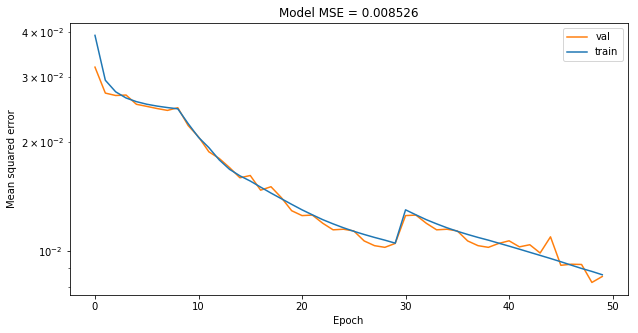

In [62]:


fig, axs = plt.subplots(1,1,figsize=(10,5))
# summarize history for accuracy
axs.plot(historyDict["val_mean_squared_error"], label = "val", color = "C1")
axs.plot(historyDict["mean_squared_error"], label = "train", color = "C0")

axs.set_title('Model MSE = '+ str((historyDict['val_mean_squared_error'][-1]))[:8])
axs.set_ylabel('Mean squared error')
axs.set_xlabel('Epoch')
axs.legend( loc='best')
plt.yscale('log') #logarithmic scale for y axis
fig.savefig(os.path.join(figDir, modelName + '_training.png'))


___

## Evaluate accuracy on test data

___

In [51]:
# from keras.models import load_model

# modelPath = os.path.join(savedModels, "Opt_rmsprop__Dro_0__Num_512_512_512_16__Wei_0_2019_06_11__11_27_06_fullActuated.h5")

# model = load_model(modelPath)

# # load scalers
# scalerX = pickle.load(open("D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput_twoTorque\scalerX_fullact.pkl", "rb"))
# scalerY = pickle.load(open("D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput_twoTorque\scalerY_fullact.pkl", "rb"))


In [63]:

# predict
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(scalerY.inverse_transform(Ytest_scaled), columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()



,Fx,Fy,tau,tau_w,Fx_pred,Fy_pred,tau_pred,tau_w_pred
0,8904.784685,5577.778325,799932.656919,61301.505115,8015.292480,12181.365234,765089.12500,58801.679688
1,16864.812183,30310.800111,-737949.278098,-97316.403803,4740.777344,8495.784180,-803938.93750,-86958.945312
2,23403.157090,14329.225157,-575984.856139,87908.705311,9076.816406,3442.428955,-490546.28125,94033.742188
3,-3112.164797,-2597.250264,617346.567027,-53108.537683,-304.543518,-2040.872314,385517.31250,-66059.882812
4,227.692545,17915.492009,967963.511996,52430.831318,3339.411865,6927.043457,752523.00000,57234.535156


In [64]:

# # predict on training data
# Ytest_pred = model.predict(Xtrain_scaled)


# # make data frames
# XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtrain_scaled), columns = Xtrain.columns)
# YtestDF = pd.DataFrame(scalerY.inverse_transform(Xtrain_scaled), columns = Ytrain.columns)
# YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytrain_scaled), columns = Ytrain.columns+ "_pred")

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
# df_c.head()



In [65]:
df_c = df_c.iloc[:10000, :]

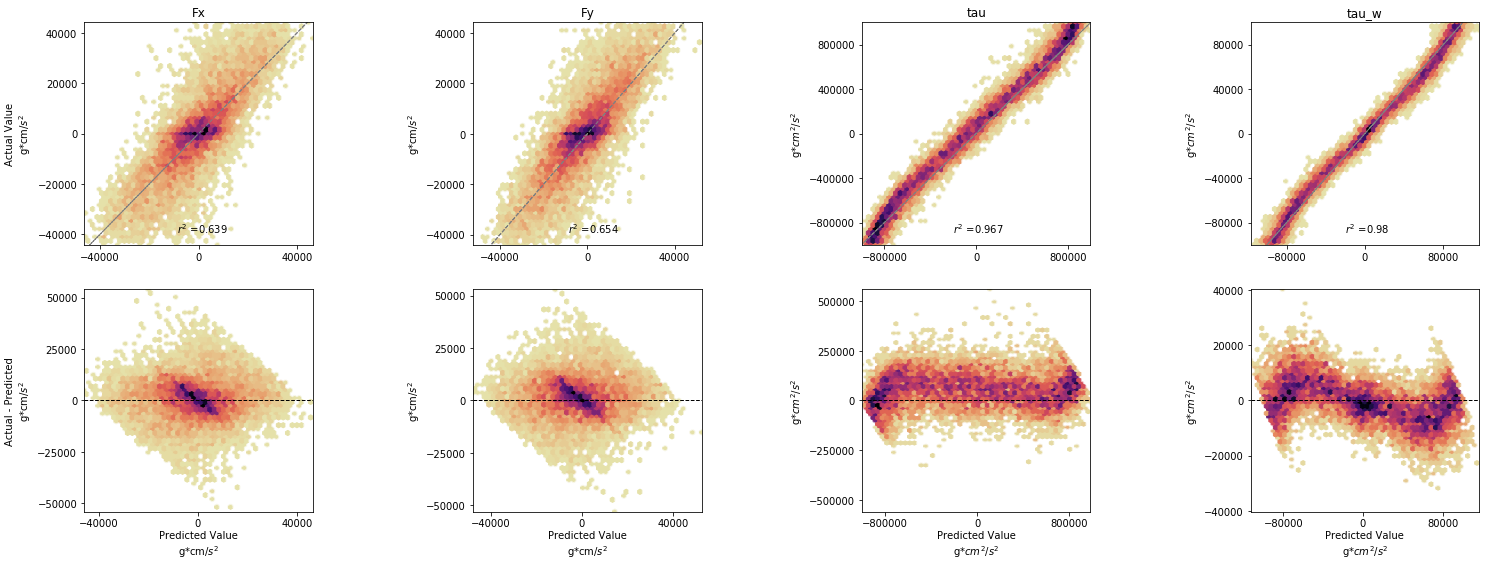

In [66]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker

M = 3
yticks = ticker.MaxNLocator(M)

plt.close("all")
fig, axs = plt.subplots(2,4, figsize=np.array([25, 9]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.7)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r"g*cm/$s^2$", r"g*cm/$s^2$", r"g*$cm^2$/$s^2$", r"g*$cm^2$/$s^2$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, df_c.shape[1] //2):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(5))

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
                 df_c.loc[:,YtestDF.columns[ii]], 
                 'grey', linewidth = 1, linestyle  = "--")

    # annotate with R^2
    axs[ii].text(np.max(df_c.loc[:,YtestDF.columns[ii]])*-0.2, 
                 np.min(df_c.loc[:,YtestDF.columns[ii]])*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(df_c.shape[1]//2, df_c.shape[1])):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[plotNum].set_xlabel("Predicted Value\n" + ylabs[jj])

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])


fig.savefig(os.path.join(figDir, "PredVActual_fullAct" + modelName + ".png"), dpi = 500, bbox_inches='tight')
plt.show()
# plt.close()